# Query Generation 

In [29]:
import sys
from pathlib import Path
import re
from os import getenv
import pandas as pd
import numpy as np
from openai import OpenAI

repo_root = Path(".").resolve().parents[1]
sys.path.append(str(repo_root / 'src'))


In [30]:
import pickle

# Load all_bayesian_networks from disk
with open("all_bayesian_networks.pkl", "rb") as f:
    all_bayesian_networks = pickle.load(f)

import pandas as pd

# Load df from CSV
df = pd.read_csv("bayesian_networks_metadata.csv")

In [31]:
# For each Bayesian network, generate n queries using generate_queries, run them, and collect results
from experiments.query_generation import generate_queries
from experiments.bn_query_sweep import get_query_metadata
from pgmpy.inference import VariableElimination

# Store all queries for later recovery: a list of lists (per BN)
all_bn_queries = []
query_rows = []

for idx, bn_dict in enumerate(all_bayesian_networks):
    bn = bn_dict["bn"]
    # Use a different seed per BN for query generation for reproducibility
    query_seed = 1000 + idx
    # Generate queries for this BN
    queries = generate_queries(
        bn,
        num_queries=1,
        query_node_counts=(1, 2),
        evidence_counts=(1, 2),
        #distance_buckets=[(1, 1), (2, 3), (1, 3)],
        distance_buckets=[(1, 100)],
        seed=query_seed,
    )
    all_bn_queries.append(queries)
    # Get the BN's properties from the main df
    bn_row = df.iloc[idx].to_dict()
    for qidx, query in enumerate(queries):
        # Prepare inference
        infer = VariableElimination(bn)
        # Query variables and their states
        query_vars = [v for v, _ in query.targets]
        query_states = [s for _, s in query.targets]
        # Evidence dict: variable -> state
        evidence = query.evidence if query.evidence else None
        evidence_nodes = list(query.evidence.keys()) if query.evidence else []

        # Get query metadata
        query_metadata = get_query_metadata(bn, query_vars, evidence_nodes)

        # Compute exact probability (with evidence)
        try:
            result = infer.query(variables=query_vars, evidence=evidence, show_progress=False)
            assignment = dict(zip(query_vars, query_states))
            prob = result.get_value(**assignment)
        except Exception as e:
            prob = None

        # Compute prior probability (no evidence)
        try:
            prior_result = infer.query(variables=query_vars, evidence=None, show_progress=False)
            prior_assignment = dict(zip(query_vars, query_states))
            prior_prob = prior_result.get_value(**prior_assignment)
        except Exception as e:
            prior_prob = None

        # Collect all info for the table, merging BN and query properties (no LLM here)
        row = dict(bn_row)  # copy BN properties
        row.update({
            "bn_index": idx,
            "query_index": qidx,
            "query_vars": str(query_vars),
            "query_states": str(query_states),
            "evidence": str(query.evidence),
            "distance": query.meta.get("min_target_evidence_distance"),
            "num_evidence": query.meta.get("num_evidence_nodes"),
            "num_target": query.meta.get("num_query_nodes"),
            "probability": prob,
            "prior_probability": prior_prob,  # add the prior probability as a new column
        })
        # Add query metadata to the row
        row.update(query_metadata)
        query_rows.append(row)

# Convert to DataFrame and display
full_df = pd.DataFrame(query_rows)
print(f"Total queries: {len(full_df)}")
full_df

Total queries: 36


,achieved_tw,naming,alpha,seed,variant_index,num_edges,num_nodes,num_nodes/num_edges,avg_markov_blanket_size,bn_index,...,prior_probability,avg_markov_blanket_size_evidence,avg_markov_blanket_size_target,min_distance_target_evidence,min_distance_target_target,min_distance_evidence_evidence,all_evidence_are_roots,all_evidence_are_leaves,all_target_are_roots,all_target_are_leaves
0,2,confusing,1.0,42,0,4,4,1.000000,2.000000,0,...,0.756807,1.5,2.0,1,NaN,2.0,False,False,False,True
1,2,confusing,0.5,43,0,4,4,1.000000,2.000000,1,...,0.000008,1.5,2.5,1,1.0,2.0,False,True,False,False
2,3,confusing,1.0,44,0,6,4,0.666667,3.000000,2,...,0.270983,3.0,3.0,1,1.0,NaN,True,False,False,False
3,3,confusing,0.5,45,0,6,4,0.666667,3.000000,3,...,0.422790,3.0,3.0,1,NaN,NaN,False,True,False,False
4,2,confusing,1.0,46,0,6,6,1.000000,2.666667,4,...,0.047928,3.0,1.5,1,2.0,NaN,True,False,False,False
5,2,confusing,0.5,47,0,6,6,1.000000,2.666667,5,...,0.964981,2.0,1.0,3,NaN,NaN,False,False,True,False
6,4,confusing,1.0,48,0,13,6,0.461538,5.000000,6,...,0.265194,4.0,4.5,1,1.0,NaN,False,False,False,False
7,4,confusing,0.5,49,0,13,6,0.461538,5.000000,7,...,0.031506,5.0,4.0,1,NaN,NaN,False,False,False,False
8,2,confusing,1.0,50,0,8,8,1.000000,3.250000,8,...,0.301062,3.0,4.0,1,NaN,NaN,False,False,False,False
9,2,confusing,0.5,51,0,8,8,1.000000,3.250000,9,...,0.220669,2.0,2.0,1,2.0,NaN,True,False,False,False


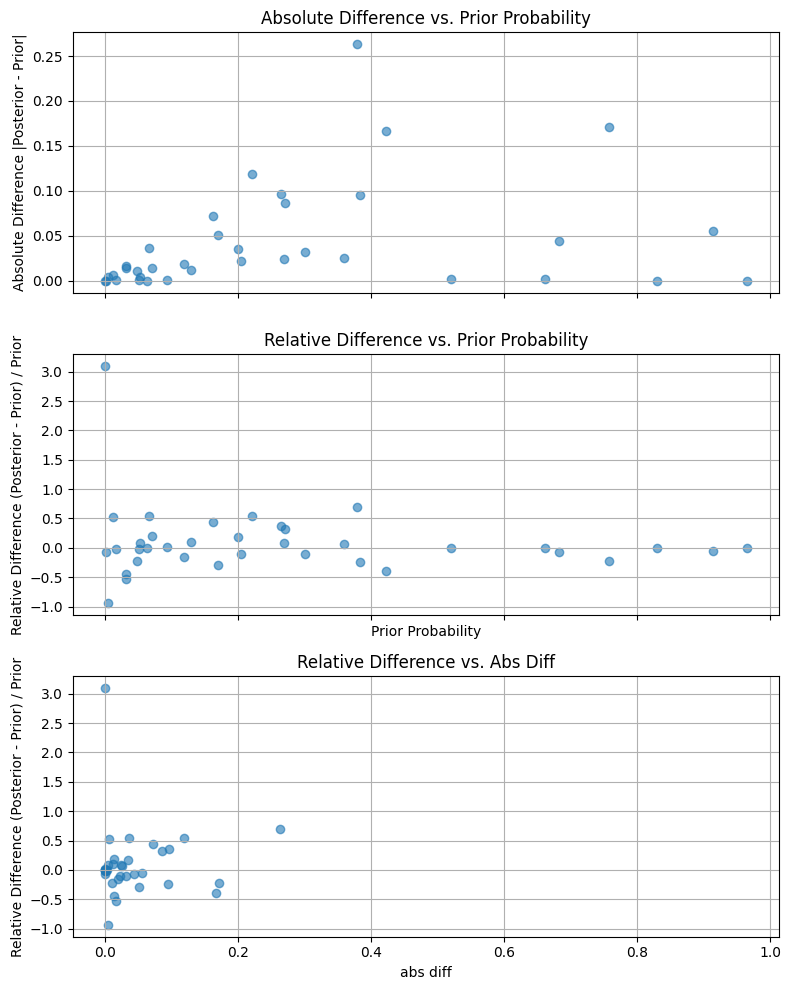

In [32]:
import matplotlib.pyplot as plt
import numpy as np

prior = full_df["prior_probability"].astype(float)
posterior = full_df["probability"].astype(float)

# Mask out rows where prior or posterior is NaN
mask = ~(prior.isna() | posterior.isna())
prior = prior[mask]
posterior = posterior[mask]

abs_diff = np.abs(posterior - prior)
# Avoid division by zero; mask entries where prior=0 for rel_diff
with np.errstate(divide='ignore', invalid='ignore'):
    rel_diff = np.where(prior != 0, (posterior - prior) / prior, np.nan)

fig, axs = plt.subplots(3, 1, figsize=(8, 10), sharex=True)

# Absolute difference plot
axs[0].scatter(prior, abs_diff, alpha=0.6)
axs[0].set_ylabel("Absolute Difference |Posterior - Prior|")
axs[0].set_title("Absolute Difference vs. Prior Probability")
axs[0].grid(True)

# Relative difference plot
axs[1].scatter(prior, rel_diff, alpha=0.6)
axs[1].set_xlabel("Prior Probability")
axs[1].set_ylabel("Relative Difference (Posterior - Prior) / Prior")
axs[1].set_title("Relative Difference vs. Prior Probability")
axs[1].grid(True)


axs[2].scatter(abs_diff, rel_diff, alpha=0.6)
axs[2].set_xlabel("abs diff")
axs[2].set_ylabel("Relative Difference (Posterior - Prior) / Prior")
axs[2].set_title("Relative Difference vs. Abs Diff")
axs[2].grid(True)


plt.tight_layout()
plt.show()


Number of cases where prior probability equals posterior: 3


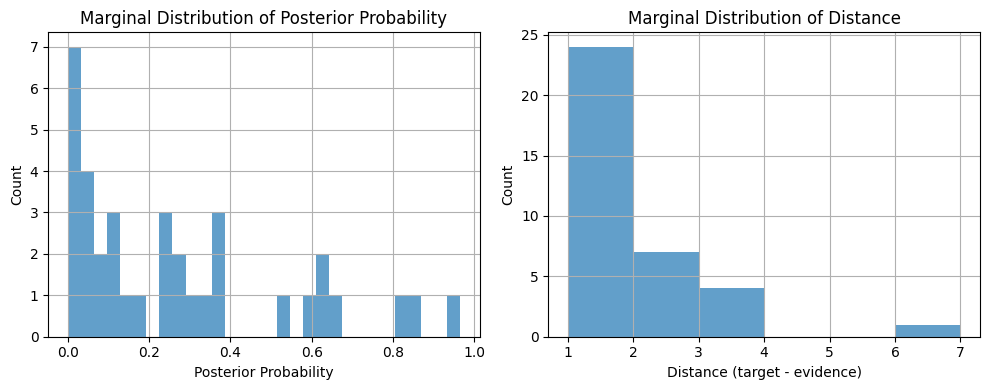

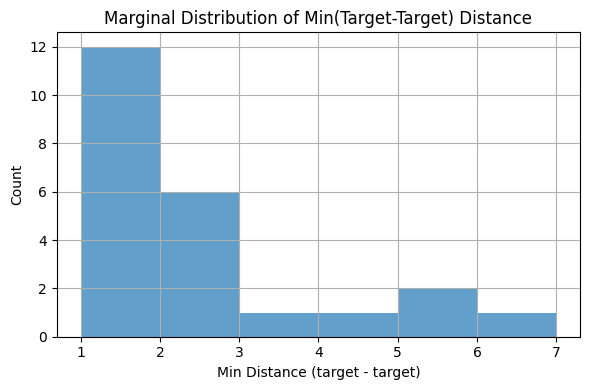

In [33]:
equal_cases = (full_df["prior_probability"] == full_df["probability"]).sum()
print(f"Number of cases where prior probability equals posterior: {equal_cases}")

# Plot the marginal distribution of probability
plt.figure(figsize=(10, 4))
plt.subplot(1, 2, 1)
full_df["probability"].astype(float).hist(bins=30, alpha=0.7)
plt.xlabel("Posterior Probability")
plt.ylabel("Count")
plt.title("Marginal Distribution of Posterior Probability")
plt.grid(True)

# Plot the marginal distribution of distance between target and evidence
plt.subplot(1, 2, 2)
if "min_distance_target_evidence" in full_df.columns:
    full_df["min_distance_target_evidence"].astype(float).hist(bins=range(int(full_df["min_distance_target_evidence"].min()), int(full_df["min_distance_target_evidence"].max()) + 2), alpha=0.7)
    plt.xlabel("Distance (target - evidence)")
else:
    full_df["distance"].astype(float).hist(bins=30, alpha=0.7)
    plt.xlabel("Distance (target - evidence)")
plt.ylabel("Count")
plt.title("Marginal Distribution of Distance")
plt.grid(True)

plt.tight_layout()
plt.show()

# Plot the marginal distribution of min distance between target and target
plt.figure(figsize=(6, 4))
if "min_distance_target_target" in full_df.columns:
    min_dist_t2t = full_df["min_distance_target_target"].astype(float)
    bins = range(int(min_dist_t2t.min()), int(min_dist_t2t.max()) + 2)
    min_dist_t2t.hist(bins=bins, alpha=0.7)
    plt.xlabel("Min Distance (target - target)")
    plt.title("Marginal Distribution of Min(Target-Target) Distance")
    plt.grid(True)
    plt.ylabel("Count")
    plt.tight_layout()
    plt.show()
else:
    print("Column 'min_distance_target_target' not found in DataFrame.")



In [ ]:
# Keep only queries where absolute value of relative difference > 0.5 and absolute difference > 0.1
# Store them for further analysis
full_df["abs_diff"] = abs_diff
full_df["rel_diff"] = rel_diff
full_df = full_df[(full_df["rel_diff"].abs() > 0.5) & (full_df["abs_diff"] > 0.1)].reset_index(drop=True)
full_df

In [ ]:
# Choose a row index from full_df to analyze
test_row_index = 0  # Change this to any valid row index

print("=" * 80)
print(f"TESTING QUERY-SPECIFIC COMPLEXITY COMPUTATION FOR ROW {test_row_index}")
print("=" * 80)

# Compute complexity for the selected row
complexity_result = compute_query_complexity(full_df, all_bayesian_networks, test_row_index, verbose=True)

print("\n" + "=" * 80)
print("DETAILED COMPLEXITY METRICS:")
print("=" * 80)

# Display the results in a nice format
for key, value in complexity_result.items():
    if key not in ['elimination_order', 'complete_elimination_order', 'factor_sizes', 'query_vars', 'query_states', 'evidence', 'keep_vars', 'eliminate_vars']:
        print(f"{key:25}: {value}")
    elif key in ['elimination_order', 'complete_elimination_order']:
        print(f"{key:25}: {value[:5]}... (showing first 5 of {len(value)})")
    elif key == 'factor_sizes':
        print(f"{key:25}: {value[:5]}... (showing first 5 of {len(value)})")
    else:
        print(f"{key:25}: {value}")

print("\n" + "=" * 80)
print("FACTOR SIZE PROGRESSION:")
print("=" * 80)
for i, size in enumerate(complexity_result['factor_sizes']):
    print(f"Step {i+1:2d}: {size:8,} entries")

print("\n" + "=" * 80)
print("QUERY-SPECIFIC ANALYSIS:")
print("=" * 80)
print(f"Query variables kept: {complexity_result['keep_vars']}")
print(f"Variables eliminated: {complexity_result['eliminate_vars']}")
print(f"Variables eliminated: {complexity_result['num_eliminated_vars']}/{complexity_result['num_vars']} ({complexity_result['num_eliminated_vars']/complexity_result['num_vars']*100:.1f}%)")


In [ ]:
complexity_df = compute_all_query_complexities(full_df, all_bayesian_networks, verbose=True)
print("\nComplexity DataFrame:")
display(complexity_df.head())

In [ ]:
# Optional: Call LLM on a subset AFTER query generation
# Provide indices of rows in full_df for which to call the LLM.
# Import _parse_field from bn_query_sweep instead of defining it locally
from bn_query_sweep import _parse_field, call_llm_for_query

# Ensure LLM columns exist
if 'llm_probability' not in full_df.columns:
    full_df['llm_probability'] = None
if 'llm_response' not in full_df.columns:
    full_df['llm_response'] = None


ENABLE_LLM_CALLS = True
if ENABLE_LLM_CALLS:
    # Select which rows to send to LLM (example below commented out)
    #selected_indices = list(full_df.sample(n=40, random_state=0).index)
    selected_indices = list(full_df.sample(n=5, random_state=0).index)
    #selected_indices = list(full_df.index)

    for ridx in selected_indices:
        row = full_df.iloc[ridx]
        bn = all_bayesian_networks[int(row['bn_index'])]['bn']
        query_vars = _parse_field(row['query_vars']) or []
        query_states = _parse_field(row['query_states']) or []
        evidence = _parse_field(row['evidence']) or None
        print(f"Processing BN {int(row['bn_index'])}/{len(all_bayesian_networks)}, Query {int(row['query_index'])}...")
        llm_prob, llm_response = call_llm_for_query(bn, query_vars, query_states, evidence)
        full_df.at[ridx, 'llm_probability'] = llm_prob
        full_df.at[ridx, 'llm_response'] = llm_response
else:
    print("LLM calls are disabled. Skipping batch LLM processing.")
    print(f"Would have processed {len(full_df)} queries if LLM calls were enabled.")

ENABLE_LLM_CALLS = False

In [ ]:
import datetime
from pathlib import Path

timestamp = datetime.datetime.now().strftime('%Y%m%d_%H%M%S')
# Add the model as a column. If not present, add and set to used model (from call_llm_for_query)
used_model = MODEL
if 'model' not in full_df.columns:
    full_df['model'] = used_model
else:
    full_df['model'].fillna(used_model, inplace=True)

# Drop BN and query identifier columns before saving (if present)
cols_to_drop = [col for col in ['bn_index', 'query_index'] if col in full_df.columns]
full_df_no_ids = full_df.drop(columns=cols_to_drop) if cols_to_drop else full_df

# Instead of relying on out_query_csv, construct the path directly
out_llm_csv = Path(f"llm_query_results_{timestamp}_with_llm.csv")
full_df_no_ids.to_csv(out_llm_csv, index=False)
print("Saved DataFrame with LLM responses to", out_llm_csv)


In [ ]:
# Print rows with non-empty llm_probability
llm_rows = full_df[full_df['llm_probability'].notna()]
print(f"Found {len(llm_rows)} rows with LLM probability values:")
print("=" * 80)
display(llm_rows)


In [ ]:
# Display LLM performance statistics
print("LLM Performance Analysis:")
print("=" * 50)

# Count successful LLM responses
successful_llm = full_df['llm_probability'].notna().sum()
total_queries = len(full_df)
print(f"Successful LLM responses: {successful_llm}/{total_queries} ({successful_llm/total_queries*100:.1f}%)")

# Save enhanced results with LLM data
enhanced_csv = repo_root / 'notebooks' / 'graph_generation' / 'bn_generation_sweep_queries_with_llm.csv'
full_df.to_csv(enhanced_csv, index=False)
print(f'Saved enhanced results with LLM data to {enhanced_csv}')

In [ ]:
# Calculate accuracy metrics for successful responses
if successful_llm > 0:
    # Filter to only successful LLM responses
    successful_df = full_df[full_df['llm_probability'].notna() & full_df['probability'].notna()]
    
    if len(successful_df) > 0:
        # Calculate absolute errors
        successful_df = successful_df.copy()
        successful_df['abs_error'] = abs(successful_df['llm_probability'] - successful_df['probability'])
        successful_df['rel_error'] = successful_df['abs_error'] / successful_df['probability']
        
        print(f"\nAccuracy Metrics (for {len(successful_df)} successful responses):")
        print(f"Mean Absolute Error: {successful_df['abs_error'].mean():.6f}")
        print(f"Mean Relative Error: {successful_df['rel_error'].mean():.6f}")
        print(f"Max Absolute Error: {successful_df['abs_error'].max():.6f}")
        print(f"Max Relative Error: {successful_df['rel_error'].max():.6f}")
        
        # Show some examples
        print(f"\nFirst 5 successful responses:")
        display(successful_df[['query_vars', 'query_states', 'evidence', 'probability', 'llm_probability', 'abs_error']].head())
    else:
        print("No successful LLM responses with exact inference results to compare.")
else:
    print("No successful LLM responses.")

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Set up the plotting style
plt.style.use('default')
sns.set_palette("husl")

# Filter to only successful LLM responses with exact inference results
plot_df = full_df[full_df['llm_probability'].notna() & full_df['probability'].notna()].copy()
plot_df['abs_error'] = abs(plot_df['llm_probability'] - plot_df['probability'])

if len(plot_df) > 0:
    # Identify all BN and query property columns (exclude result columns)
    exclude_cols = {'bn_index', 'query_vars', 'query_states', 'evidence', 'probability', 
                   'llm_probability', 'llm_response', 'abs_error', 'rel_error', 'target_tw', 'n', 'seed', 'variant_index',
                   'alpha', 'determinism', 'arity', 'query_index', 
                   'achieved_tw', 'num_nodes'}
    
    # Get all columns that are BN or query properties
    property_cols = [col for col in full_df.columns if col not in exclude_cols]
    
    # Calculate number of subplots needed
    n_props = len(property_cols)
    n_cols = min(4, n_props)  # Max 4 columns
    n_rows = (n_props + n_cols - 1) // n_cols  # Ceiling division
    
    # Create figure with subplots for all properties
    fig, axes = plt.subplots(n_rows, n_cols, figsize=(4*n_cols, 3*n_rows))
    fig.suptitle('Absolute Error by BN and Query Properties', fontsize=16, fontweight='bold')
    
    # Flatten axes for easier indexing
    if n_props == 1:
        axes = [axes]
    elif n_rows == 1:
        axes = axes.flatten()
    else:
        axes = axes.flatten()
    
    # Create boxplots for each property
    for i, prop in enumerate(property_cols):
        ax = axes[i]
        
        # Get unique values for this property
        unique_vals = sorted(plot_df[prop].unique())
        
        # Create boxplot data
        box_data = []
        labels = []
        
        for val in unique_vals:
            subset = plot_df[plot_df[prop] == val]['abs_error']
            if len(subset) > 0:  # Only include if there's data
                box_data.append(subset.values)
                labels.append(str(val))
        
        if box_data:  # Only plot if we have data
            ax.boxplot(box_data, labels=labels)
            ax.set_title(f'Absolute Error by {prop.replace("_", " ").title()}')
            ax.set_xlabel(prop.replace("_", " ").title())
            ax.set_ylabel('Absolute Error')
            ax.grid(True, alpha=0.3)
            
            # Rotate x-axis labels if there are many unique values
            if len(labels) > 5:
                ax.tick_params(axis='x', rotation=45)
    
    # Hide unused subplots
    for i in range(n_props, len(axes)):
        axes[i].set_visible(False)
    
    plt.tight_layout()
    plt.show()
    
    # Print summary statistics for each property
    print("\nSummary Statistics by Property:")
    print("=" * 50)
    
    for prop in property_cols:
        print(f"\n{prop.upper()}:")
        prop_stats = plot_df.groupby(prop)['abs_error'].agg(['count', 'mean', 'std', 'min', 'max'])
        print(prop_stats.round(6))
        
else:
    print("No successful LLM responses with exact inference results available for plotting.")


In [ ]:
# Compute average distance of each number from 0 to 10 to all others

numbers = list(range(11))  # 0 to 10
dists = []
for x in numbers:
    distances = [abs(x - y)**2 for y in numbers]
    avg_distance = sum(distances) / len(distances)
    print(f"{x}: {avg_distance:.2f}")
    dists.append(avg_distance)

from math import sqrt
sqrt(sum(dists) / len(dists))


In [ ]:
# Improved complexity computation by removing independent and barren nodes

from experiments.bn_query_sweep import compute_query_complexity, _parse_field
from pgmpy.models import BayesianNetwork
import pandas as pd

# Choose a query to analyze
test_row_index = 0  # Change this to any valid row index

# Compute original complexity if not already computed
if 'complexity_result' not in globals():
    print("Computing original complexity first...")
    complexity_result = compute_query_complexity(full_df, all_bayesian_networks, test_row_index, verbose=False)

# Get the query information
row = full_df.iloc[test_row_index]
bn_idx = int(row['bn_index'])
bn = all_bayesian_networks[bn_idx]['bn']

query_vars = _parse_field(row['query_vars']) or []
query_states = _parse_field(row['query_states']) or []
evidence = _parse_field(row['evidence']) or {}
evidence_nodes = list(evidence.keys()) if evidence else []

print("=" * 80)
print(f"IMPROVED COMPLEXITY COMPUTATION FOR ROW {test_row_index}")
print("=" * 80)
print(f"Query: P({query_vars}={query_states} | {evidence})")
print(f"Original network: {len(bn.nodes())} nodes, {bn.number_of_edges()} edges")
print()

# Step 1: Remove variables that are independent of all target nodes given evidence
print("Step 1: Identifying independent variables...")
independent_vars = set()


# Usage:
independent_vars = find_conditionally_independent_vars(bn, query_vars, evidence_nodes)

print(f"Found {len(independent_vars)} independent variables: {sorted(independent_vars)}")

# Step 2: Remove barren nodes (iteratively)
print("\nStep 2: Identifying barren nodes...")
barren_vars = set()

# Usage:
barren_vars = identify_barren_nodes(bn, query_vars, evidence_nodes, barren_vars)

print(f"Found {len(barren_vars)} barren variables: {sorted(barren_vars)}")

# Step 3: Create reduced network
print("\nStep 3: Creating reduced network...")
vars_to_remove = independent_vars | barren_vars
vars_to_keep = set(bn.nodes()) - vars_to_remove

print(f"Removing {len(vars_to_remove)} variables, keeping {len(vars_to_keep)} variables")
print(f"Variables to keep: {sorted(vars_to_keep)}")

# Create a subgraph with only the relevant variables
reduced_bn = BayesianNetwork()
reduced_bn.add_nodes_from(vars_to_keep)

# Add edges that connect kept variables
for edge in bn.edges():
    u, v = edge
    if u in vars_to_keep and v in vars_to_keep:
        reduced_bn.add_edge(u, v)

# Copy CPDs for kept variables (only those with parents that are also kept)
for node in vars_to_keep:
    cpd = bn.get_cpds(node)
    parents = list(cpd.variables)
    parents.remove(node)  # Remove the node itself from parents list
    
    # Check if all parents are kept
    if all(p in vars_to_keep for p in parents):
        reduced_bn.add_cpds(cpd)

print(f"Reduced network: {len(reduced_bn.nodes())} nodes, {reduced_bn.number_of_edges()} edges")

# Step 4: Compute complexity on reduced network
print("\nStep 4: Computing complexity on reduced network...")
print("=" * 80)

# Create a temporary row for the reduced network
temp_row = row.copy()
temp_row['bn_index'] = -1  # Use -1 to indicate it's not in all_bayesian_networks

# Create a temporary all_bayesian_networks list
temp_all_bns = [{"bn": reduced_bn, "meta": {}}]

# Create a temporary full_df with just this row
temp_df = pd.DataFrame([temp_row])

# Compute complexity
from experiments.bn_query_sweep import compute_query_complexity as compute_complexity

complexity_reduced = compute_complexity(
    temp_df, 
    temp_all_bns, 
    0,  # row index in temp_df
    verbose=True
)

print("\n" + "=" * 80)
print("COMPARISON:")
print("=" * 80)
print(f"Original network complexity:")
print(f"  Variables: {complexity_result['num_vars']}")
print(f"  Variables to eliminate: {complexity_result['num_eliminated_vars']}")
print(f"  Induced width: {complexity_result['induced_width']}")
print(f"  Total cost: {complexity_result['total_cost']:,}")
print(f"  Max factor size: {complexity_result['max_factor_size']:,}")

print(f"\nReduced network complexity:")
print(f"  Variables: {complexity_reduced['num_vars']}")
print(f"  Variables to eliminate: {complexity_reduced['num_eliminated_vars']}")
print(f"  Induced width: {complexity_reduced['induced_width']}")
print(f"  Total cost: {complexity_reduced['total_cost']:,}")
print(f"  Max factor size: {complexity_reduced['max_factor_size']:,}")

print(f"\nReduction:")
print(f"  Variables removed: {len(vars_to_remove)} ({len(vars_to_remove)/complexity_result['num_vars']*100:.1f}%)")
print(f"  Cost reduction: {((1 - complexity_reduced['total_cost']/complexity_result['total_cost'])*100):.1f}%")
print(f"  Max factor size reduction: {((1 - complexity_reduced['max_factor_size']/complexity_result['max_factor_size'])*100):.1f}%")


IMPROVED COMPLEXITY COMPUTATION FOR ROW 0
Query: P(['L_vy01po']=['s0'] | {'K_kx9xcv': 's0', 'U_bx3bu6': 's0'})
Original network: 4 nodes, 4 edges

Step 1: Identifying independent variables...
Found 0 independent variables: []

Step 2: Identifying barren nodes...
Found 1 barren variables: ['G_2ohusw']

Step 3: Creating reduced network...
Removing 1 variables, keeping 3 variables
Variables to keep: ['K_kx9xcv', 'L_vy01po', 'U_bx3bu6']


ImportError: BayesianNetwork has been deprecated. Please use DiscreteBayesianNetwork instead.

In [7]:
full_df.columns

Index(['achieved_tw', 'naming', 'alpha', 'seed', 'variant_index', 'num_edges',
       'num_nodes', 'num_nodes/num_edges', 'avg_markov_blanket_size',
       'bn_index', 'query_index', 'query_vars', 'query_states', 'evidence',
       'distance', 'num_evidence', 'probability', 'prior_probability',
       'avg_markov_blanket_size_evidence', 'avg_markov_blanket_size_target',
       'min_distance_target_evidence', 'min_distance_target_target',
       'min_distance_evidence_evidence', 'all_evidence_are_roots',
       'all_evidence_are_leaves', 'all_target_are_roots',
       'all_target_are_leaves'],
      dtype='object')